# Text Summarization using Seq2Seq LSTM.

In [1]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data=pd.read_csv("/content/Amazon_Instant_Video_5.csv",nrows=100000)

# Drop Duplicates and NA values

In [3]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36787 entries, 0 to 37125
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   UserId                  36787 non-null  object
 1   ProductId               36787 non-null  object
 2   ProfileName             36787 non-null  object
 3   HelpfulnessNumerator    36787 non-null  int64 
 4   HelpfulnessDenominator  36787 non-null  int64 
 5   Text                    36787 non-null  object
 6   Score                   36787 non-null  int64 
 7   Summary                 36787 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.5+ MB


In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [6]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [7]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [8]:
cleaned_text[:5]

['big expectations love english tv particular investigative detective stuff guy really boring appeal',
 'highly recommend series must anyone yearning watch grown television complex characters plots keep one totally involved thank amazin prime',
 'one real snoozer believe anything read hear awful idea title means neither',
 'mysteries interesting tension robson tall blond good always believable often seemed uncomfortable',
 'show always excellent far british crime mystery showsgoes one best ever made stories well done acting top notch interesting twists realistic brutal storylines show pulls punches enters twisted minds criminals profiler psychiatrist helps northern english city police force show looks like shot manchester called another name show one episode disc excellent prayer bone seperate disc still crime shows get much better one either side ocean great show never less well made episode unfortunately like british shows get five shows year hour half shows still one could hope leas

In [9]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [10]:
cleaned_summary[:5]

['little bit boring for me',
 'excellent grown up tv',
 'way too boring for me',
 'robson green is mesmerizing',
 'robson green and great writing']

In [11]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [12]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

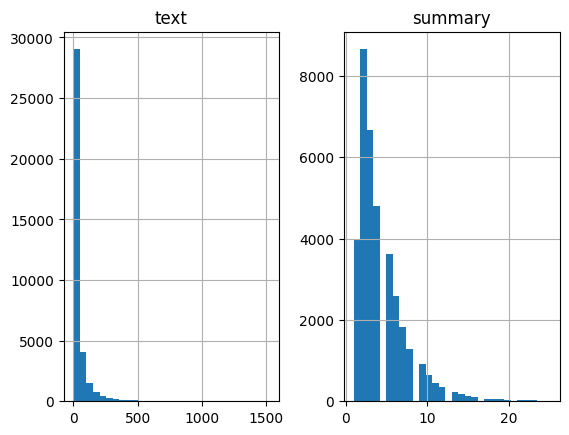

In [13]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [14]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.909707283866576


In [15]:
max_text_len=30
max_summary_len=8

In [16]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [17]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [18]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [20]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 67.78285963192856
Total Coverage of rare words: 5.261003563517288


In [21]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [22]:
x_voc

5918

In [23]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [24]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.66838046272493
Total Coverage of rare words: 7.516230825698569


In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [26]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(20279, 20279)

In [27]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [28]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 200)              1183600   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [32]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
153/153 [==============================] - 397s 2s/step - loss: 2.9036 - val_loss: 2.4517
Epoch 2/50
153/153 [==============================] - 369s 2s/step - loss: 2.4709 - val_loss: 2.4197
Epoch 3/50
153/153 [==============================] - 382s 3s/step - loss: 2.4161 - val_loss: 2.3605
Epoch 4/50
153/153 [==============================] - 356s 2s/step - loss: 2.3470 - val_loss: 2.3114
Epoch 5/50
153/153 [==============================] - 370s 2s/step - loss: 2.2932 - val_loss: 2.2555
Epoch 6/50
153/153 [==============================] - 361s 2s/step - loss: 2.2489 - val_loss: 2.2271
Epoch 7/50
153/153 [==============================] - 357s 2s/step - loss: 2.2121 - val_loss: 2.2013
Epoch 8/50
153/153 [==============================] - 356s 2s/step - loss: 2.1794 - val_loss: 2.1813
Epoch 9/50
153/153 [==============================] - 370s 2s/step - loss: 2.1506 - val_loss: 2.1461
Epoch 10/50
153/153 [==============================] - 354s 2s/step - loss: 2.1248 - val_lo

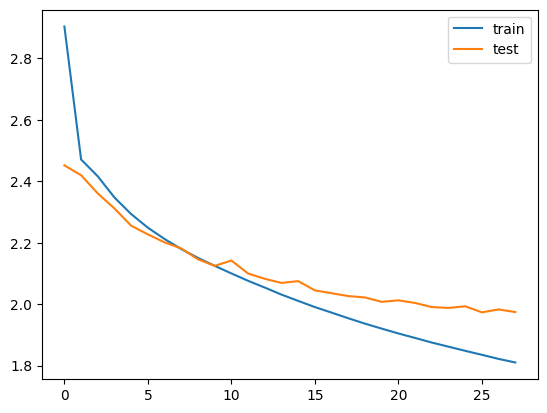

In [33]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [35]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [37]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [38]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: show always funny let crazy seasons funny characters grow think actually getting better 
Original summary: great show 
1/1 [==============================] - 0s 39ms/step
Predicted summary:  great show


Review: cannot believe canceling show given high ratings excellent writing excellent actors shame waste season better last 
Original summary: this show just gets better and better 
1/1 [==============================] - 0s 42ms/step
Predicted summary:  great show


Review: quirky fun show characters wonderful unique nicely historical references warehouse spin nice 
Original summary: quirky but fun 
1/1 [==============================] - 0s 42ms/step
Predicted summary:  love it


Review: nice download episodes miss episodes love great show 
Original summary: love it 
1/1 [==============================] - 0s 31ms/step
Predicted summary:  five stars


Review: several new question beginning new season really excited ready 
Original summary: interesting start to new season 
1/1 [==

In [61]:
data[0:3]

,UserId,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Text,Score,Summary,cleaned_text,cleaned_summary
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,0,0,"I had big expectations because I love English TV, in particular Investigative and detective stuff but this guy is really boring. It didn't appeal to me at all.",2,A little bit boring for me,big expectations love english tv particular investigative detective stuff guy really boring appeal,little bit boring for me
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,0,0,"I highly recommend this series. It is a must for anyone who is yearning to watch ""grown up"" television. Complex characters and plots to keep one totally involved. Thank you Amazin Prime.",5,Excellent Grown Up TV,highly recommend series must anyone yearning watch grown television complex characters plots keep one totally involved thank amazin prime,excellent grown up tv
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""",0,1,"This one is a real snoozer. Don't believe anything you read or hear, it's awful. I had no idea what the title means. Neither will you.",1,Way too boring for me,one real snoozer believe anything read hear awful idea title means neither,way too boring for me


In [77]:
# prompt: Can you save this trained model, I don't want to train again and again

model.save('my_model.h5')


In [ ]:
# prompt: How to call the saved model and make predictions with it

from tensorflow.keras.models import load_model
# Load the saved model
model = load_model('my_model.h5')

# Make predictions on new data
predictions = model.predict(new_data)


In [76]:
#BLEU Score of Training set
#n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_tr[i])
  candidate = decode_sequence(x_tr[i].reshape(1, max_text_len))

print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

1/1 [==============================] - 0s 26ms/step


KeyboardInterrupt: 

In [ ]:

#4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_train[i])
  candidate = decode_sequence(X_train[i].reshape(1, max_text_len))

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)

In [ ]:

#cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_train[i])
  candidate = decode_sequence(X_train[i].reshape(1, max_text_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:

#BLEU Score of Test/Validation set
#n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_test[i])
  candidate = decode_sequence(X_test[i].reshape(1, max_text_len))
print("Test/Validation Set :")
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

In [ ]:

#4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_test[i])
  candidate = decode_sequence(X_test[i].reshape(1, max_text_len))

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)


In [ ]:

#cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_test[i])
  candidate = decode_sequence(X_test[i].reshape(1, max_text_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

In [68]:
!pip install rouge

In [79]:
# prompt: Calculate ROuge scores based on above all the code, store all the original summaries and predicted summaries in a list and then calculate rouge scores using these lists


from rouge import Rouge

rouge = Rouge()

original_summaries = []
predicted_summaries = []

for i in range(0,100):
  reference = seq2summary(y_val[i])
  candidate = decode_sequence(x_val[i].reshape(1, max_text_len))

rouge_scores = rouge.get_scores(reference, candidate)

print("ROUGE-1:", rouge_scores['rouge-1']['f'])
print("ROUGE-2:", rouge_scores['rouge-2']['f'])
print("ROUGE-L:", rouge_scores['rouge-l']['f'])


1/1 [==============================] - 0s 26ms/step


TypeError: list indices must be integers or slices, not str